In [1]:
%matplotlib inline


In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/COMBAT


In [33]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd
import scipy.sparse as sp


sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3
natsort             8.1.0
nbinom_ufunc        NA
numba               0.55.1
numpy               1.21.6
packaging           21.3
pandas   

# B - Parameters

In [4]:
! ls ../../../Data/PerDataset/COMBAT

ADT_TP10KCLR_ForMAGIC.h5ad
AUC_GatePrediction_StepwiseLogistic_20230704.tsv
AUC_GatePrediction_StepwiseLogistic.tsv
COMBAT.20230927
COMBAT.20230927.Iter200
COMBAT.20230927.Iter200.Spectra_Scores.Relabeled.tsv
COMBAT.20230927.Iter200.Spectra_TPM.Relabeled.tsv
COMBAT.20230927.Iter200.Usage.Relabeled.tsv
Combat_ADT_info_final.tsv
COMBAT.AllPBMCs.TCAT.Usage.20230910.tsv
Combat_Antibody_Info.xlsx
COMBAT-CITESeq-DATA.h5ad
COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad
COMBAT-CITESeq-DATA.raw.h5ad
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831FiltForcNMF.h5ad
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831metadata_PhenotypeAssociations.TCAT.20231031.FiltSingletons.tsv
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831metadata_PhenotypeAssociations.tsv
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831metadata.tsv
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831RNA_and_ADT.TP10K.h5ad
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831RNA.HVGlist.tsv
COMBAT-CITESeq-DATA.Raw.T.ADTfixed20230831RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad
COMBAT-CITE

In [5]:
adata = sc.read('../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad')

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [6]:
adata.obs['Annotation_major_subset'].value_counts()

CD4       269661
cMono     213697
CD8       106025
NK         69927
nan        52444
B          44256
ncMono     33172
GDT         9580
DC          8959
PB          8596
DP          6561
DN          4557
MAIT        4541
HSC         1868
PLT         1563
iNKT         372
RET          304
Mast          65
Name: Annotation_major_subset, dtype: int64

In [59]:
params = {
'harmony_vars' : ['COMBAT_participant_timepoint_ID'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 65,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 23,
'n_adt_pcs' : 21,
'name_addition' : '.B.20231230.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}


if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths   
                                                                                            

{'Original': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/

# B - Run pipeline

In [20]:
adata = adata[adata.obs['Annotation_major_subset']=='B', :]

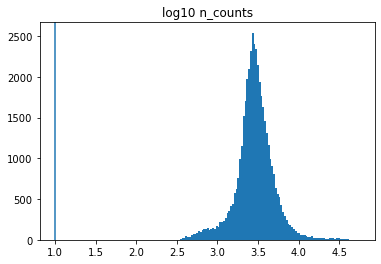

In [21]:


if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index
p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

In [22]:
params['harmony_vars']

['COMBAT_participant_timepoint_ID']

In [23]:
pd.crosstab(adata.obs['COMBAT_participant_timepoint_ID'], adata.obs['Source'])

Source,HV,COVID_MILD,COVID_SEV,COVID_CRIT,COVID_HCW_MILD,COVID_LDN,Sepsis,Flu
COMBAT_participant_timepoint_ID,,,,,,,,
G05061-Ja005,0,0,0,0,380,0,0,0
G05064-Ja005,0,0,0,0,305,0,0,0
G05073-Ja005,0,0,0,0,433,0,0,0
G05077-Ja005,0,0,0,0,314,0,0,0
G05078-Ja005,0,0,0,0,129,0,0,0
...,...,...,...,...,...,...,...,...
U00607-Ua005,0,0,0,0,0,0,0,37
U00613-Ua005,0,0,0,0,0,0,0,76
U00617-Ua005,0,0,0,0,0,0,0,34


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


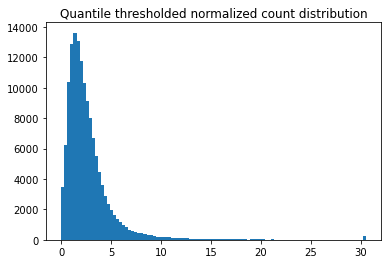

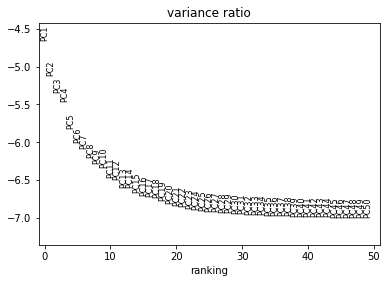

2023-12-31 02:27:38,960 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-31 02:28:28,466 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-31 02:28:29,297 - harmonypy - INFO - Iteration 1 of 20
2023-12-31 02:30:43,191 - harmonypy - INFO - Iteration 2 of 20
2023-12-31 02:32:09,805 - harmonypy - INFO - Iteration 3 of 20
2023-12-31 02:33:36,914 - harmonypy - INFO - Iteration 4 of 20
2023-12-31 02:34:16,326 - harmonypy - INFO - Iteration 5 of 20
2023-12-31 02:34:45,014 - harmonypy - INFO - Iteration 6 of 20
2023-12-31 02:35:02,380 - harmonypy - INFO - Iteration 7 of 20
2023-12-31 02:35:20,625 - harmonypy - INFO - Iteration 8 of 20
2023-12-31 02:35:37,041 - harmonypy - INFO - Iteration 9 of 20
2023-12-31 02:35:53,630 - harmonypy - INFO - Iteration 10 of 20
2023-12-31 02:36:10,054 - harmonypy - INFO - Iteration 11 of 20
2023-12-31 02:36:25,604 - harmonypy - INFO - Iteration 12 of 20
2023-12-31 02:36:41,988 - harmonypy - INFO - Iteration 13 of

In [26]:
(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [35]:
adata_tp10k.X = sp.csr_matrix(adata_tp10k.X)

In [43]:
adata_tp10k.var.iloc[:, :7] = adata_tp10k.var.iloc[:, :7].astype(str)

In [49]:
adata_tp10k.var['highly_variable'] = adata_tp10k.var['highly_variable'].astype(str)

In [50]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [51]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [52]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [53]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [54]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((44256, 20807), (44031, 2000), (44031, 20807))

In [55]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.FiltForcNMF.h5ad'

In [56]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


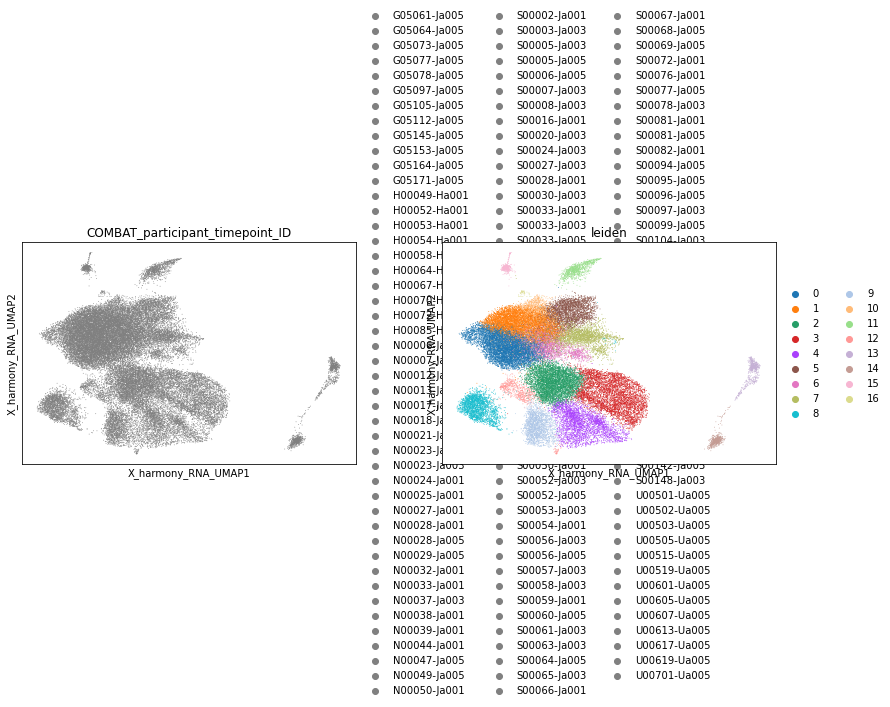

In [57]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

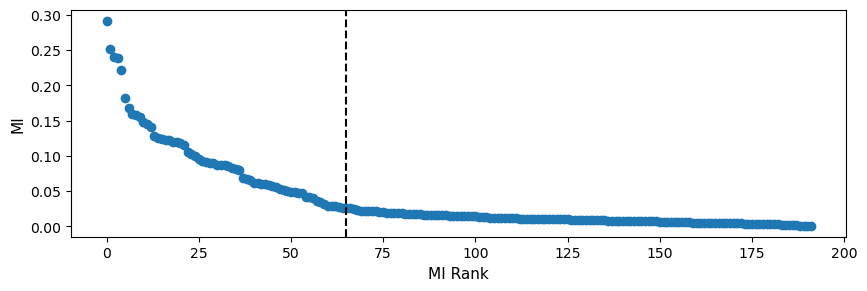

In [60]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [61]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


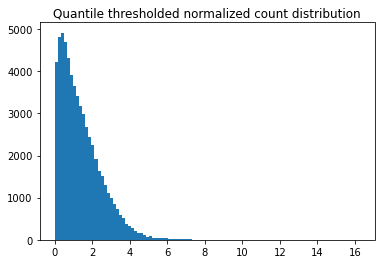

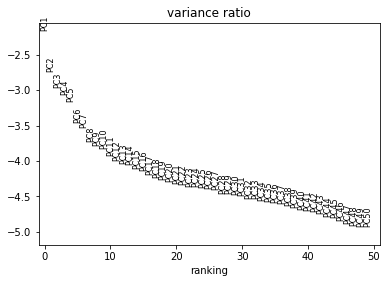

2023-12-31 03:35:29,364 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-31 03:35:51,062 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-31 03:35:51,536 - harmonypy - INFO - Iteration 1 of 20
2023-12-31 03:36:21,197 - harmonypy - INFO - Iteration 2 of 20
2023-12-31 03:36:49,550 - harmonypy - INFO - Iteration 3 of 20
2023-12-31 03:37:19,811 - harmonypy - INFO - Iteration 4 of 20
2023-12-31 03:37:37,833 - harmonypy - INFO - Iteration 5 of 20
2023-12-31 03:37:53,635 - harmonypy - INFO - Iteration 6 of 20
2023-12-31 03:38:08,683 - harmonypy - INFO - Iteration 7 of 20
2023-12-31 03:38:22,922 - harmonypy - INFO - Iteration 8 of 20
2023-12-31 03:38:37,856 - harmonypy - INFO - Iteration 9 of 20
2023-12-31 03:38:52,715 - harmonypy - INFO - Iteration 10 of 20
2023-12-31 03:39:08,095 - harmonypy - INFO - Iteration 11 of 20
2023-12-31 03:39:31,693 - harmonypy - INFO - Iteration 12 of 20
2023-12-31 03:39:55,436 - harmonypy - INFO - Iteration 13 of

In [63]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [64]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [65]:
adata_ADT_c

AnnData object with n_obs × n_vars = 44031 × 65
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 

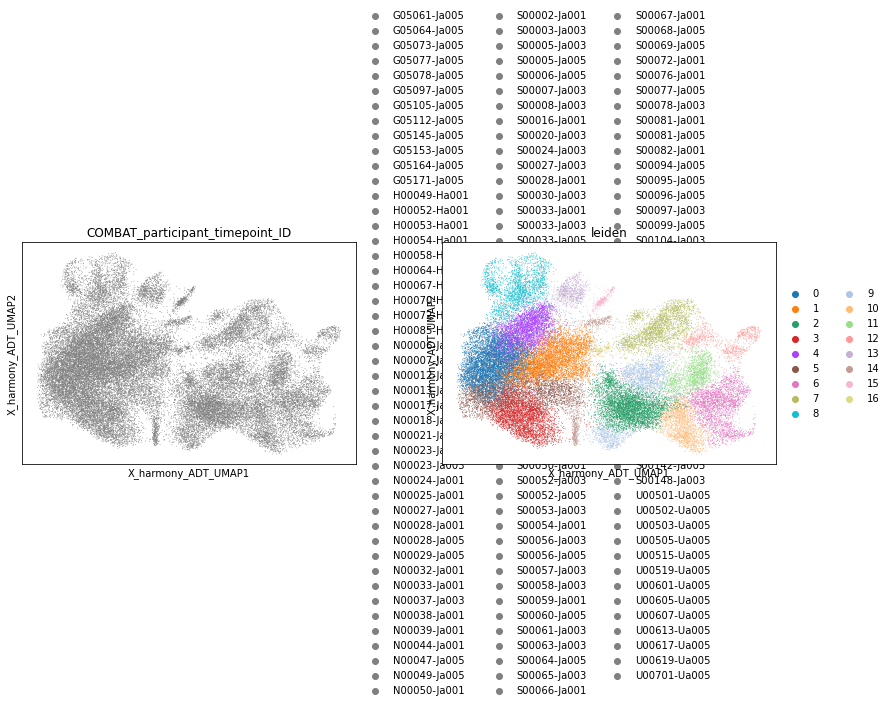

In [66]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [67]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.

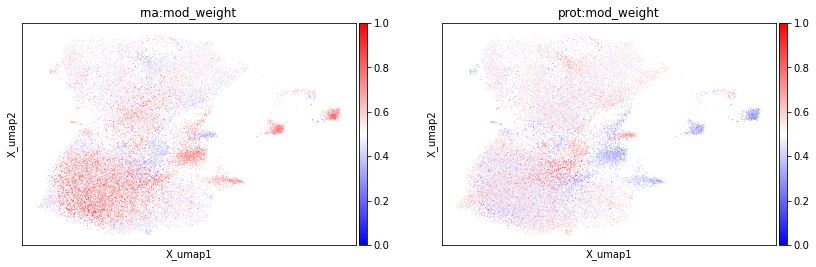

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/tools/_leiden.py:160: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  categories=natsorted(map(str, np.unique(groups))),


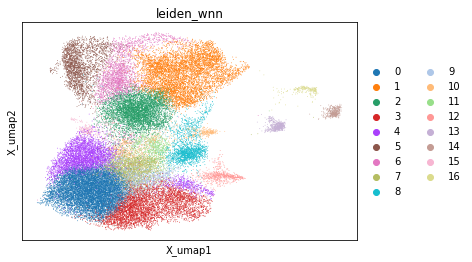

In [68]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [69]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [70]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [71]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [72]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,STAG3,SESN1,ZBTB16,CNTNAP2,RASL11A,UACA,SLC38A11,FAM177B,DSP,SPINK2,MMRN1,CEMIP2,KRT18,ZDHHC19,YBX3,SCN3A,IGKV1-8,GNG8,MLLT3,GAB1
1,EEF1A1,B2M,RPLP1,HSPA8,AIM2,RPL41,RPS12,COCH,SCIMP,SSPN,CPNE5,S100A10,RPS8,RPL10,TEX9,CD74,VIM,ZBTB38,LYPLAL1,PDE4D
2,EEF1A1,GPR183,AIM2,RPL10,RPS8,TNFRSF13B,RPS12,CLECL1,RPL41,GNG11,FCRL2,CD27,IGHG2,B2M,GPM6A,GALNTL6,PMAIP1,CTSH,MYC,KLK1
3,CD9,JUP,IGLL5,PLD4,NEIL1,SOX4,PCDH9,MYO7B,LIMS2,IGHV5-78,TCL1B,MACROD2,CCDC191,BMP3,CCL4,IL7R,YBX3,PPP1R14A,H2AC6,AEBP1
4,IGLC3,IGLV2-14,IGLC2,CD9,IGLC7,IGLC6,NEIL1,IGLV2-5,MYO7B,CCL4,IGLV2-23,IGLV4-69,IGLV9-49,BMP3,DSP,MACROD2,IGLV1-40,TCL1B,IGLVI-70,IGLV3-16
5,CD74,FGR,B2M,FCRL5,CIB1,HCK,FCRL3,PLEK,S100A11,SCIMP,ADGRE5,TMSB4X,GRN,TUBB6,THEMIS2,LRMP,FCRL2,TNFRSF1B,MS4A7,SLC11A1
6,B2M,RPL41,RPS8,CD74,RPLP1,RPL28,RPL10,EEF1A1,RPS12,TNFRSF13B,ACP5,MT-CO1,MT-CO2,PPIA,CIB1,TMSB4X,RPS26,PFN1,VIM,CD1C
7,STAG3,SESN1,ZBTB16,SPINK2,RASL11A,FAM177B,GAB1,CD9,PCDH9,FCER1G,TCL1B,IGKV1-8,DUSP6,CNTNAP2,CEMIP2,IL7R,CCL4,ANXA1,TYROBP,CD2
8,PCDH9,CEMIP2,POU3F3,CR2,SPTBN1,TTN,MUC12,GRIP1,B4GALT1,COL4A4,MYO1E,SEL1L,SYNE2,DOP1B,GAB1,ZBTB16,KLHL14,GOLGB1,DSP,SCN3A
9,IFITM1,IFI44L,XAF1,PLSCR1,MX2,EPSTI1,IFIT3,IRF7,MX1,IFIT1,ISG15,SAMD9L,IFI6,STAT1,OAS3,USP18,IFI44,OAS1,HERC5,PARP9


In [73]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD305,AB_CD73,AB_CD272,AB_CD40,AB_CD47,AB_CD185,AB_CD23,AB_CD124,AB_HLA-DR,AB_CD21
1,AB_HLA_A_B_C,AB_CD58,AB_CD49d,AB_CD82,AB_CD99,AB_CD27-1,AB_CD35,AB_CD224,AB_CD95,AB_CD267
2,AB_CD45RA,AB_CD24,AB_CD32,AB_CD267,AB_CD70,AB_CD44-1,AB_CD82,AB_CD25,AB_CD27-1,AB_CD52
3,AB_Iglightchaink,AB_IgD,AB_CD38-1,AB_CD305,AB_IgM,AB_CD81,AB_CD10,AB_CD79b,AB_CD5,AB_Integrin-7
4,AB_Iglightchainl,AB_IgD,AB_CD305,AB_CD21,AB_IgM,AB_CD81,AB_Integrin-7,AB_CD185,AB_CD272,AB_CD31
5,AB_CD19,AB_CD20,AB_CD32,AB_HLA_A_B_C,AB_CD11c,AB_CD307e,AB_CD52,AB_CD85j,AB_CD107a,AB_CD82
6,AB_CD1c,AB_CD82,AB_IgM,AB_CD58,AB_HLA_A_B_C,AB_CD1d,AB_CD49d,AB_CD27-1,AB_CD45RA,AB_CD54
7,AB_CD11b-1,AB_CD57,AB_abTCR,AB_gdTCR,AB_CCR7,AB_CD124,AB_CD5,AB_CD23,AB_CD73,AB_CD305
8,AB_CD57,AB_CD11b-1,AB_CD47,AB_abTCR,AB_IgD,AB_CD31,AB_CD21,AB_CCR7,AB_gdTCR,AB_CD184
9,AB_CD305,AB_IgD,AB_CD272,AB_CD47,AB_CD21,AB_CD31,AB_CD185,AB_CD57,AB_CD23,AB_CD40


In [74]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [75]:
paths['WNN_UMAP']

'../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [76]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [77]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [78]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [79]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [80]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


# Myeloid - parameters

In [81]:
adata = sc.read('../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad')

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


In [82]:
adata.obs['Annotation_major_subset'].value_counts()

CD4       269661
cMono     213697
CD8       106025
NK         69927
nan        52444
B          44256
ncMono     33172
GDT         9580
DC          8959
PB          8596
DP          6561
DN          4557
MAIT        4541
HSC         1868
PLT         1563
iNKT         372
RET          304
Mast          65
Name: Annotation_major_subset, dtype: int64

In [89]:
params = {
'harmony_vars' : ['COMBAT_participant_timepoint_ID'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 65,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 33,
'n_adt_pcs' : 21,
'name_addition' : '.Myeloid.20231230.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}


if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths   
                                                                                            

{'Original': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.Myeloid.20231230.RNA_and_ADT.TP10K.h5ad'

# Myeloid - Run pipeline

In [84]:
adata = adata[adata.obs['Annotation_major_subset'].isin(['cMono', 'ncMono', 'DC']), :]

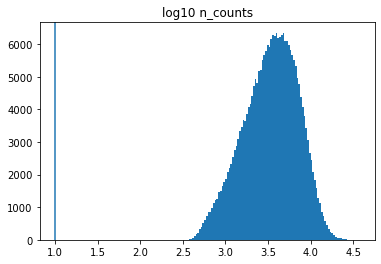

In [85]:


if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index
p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

In [86]:
params['harmony_vars']

['COMBAT_participant_timepoint_ID']

In [87]:
pd.crosstab(adata.obs['COMBAT_participant_timepoint_ID'], adata.obs['Source'])

Source,HV,COVID_MILD,COVID_SEV,COVID_CRIT,COVID_HCW_MILD,COVID_LDN,Sepsis,Flu
COMBAT_participant_timepoint_ID,,,,,,,,
G05061-Ja005,0,0,0,0,1323,0,0,0
G05064-Ja005,0,0,0,0,1761,0,0,0
G05073-Ja005,0,0,0,0,1658,0,0,0
G05077-Ja005,0,0,0,0,1236,0,0,0
G05078-Ja005,0,0,0,0,2511,0,0,0
...,...,...,...,...,...,...,...,...
U00607-Ua005,0,0,0,0,0,0,0,757
U00613-Ua005,0,0,0,0,0,0,0,386
U00617-Ua005,0,0,0,0,0,0,0,127


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


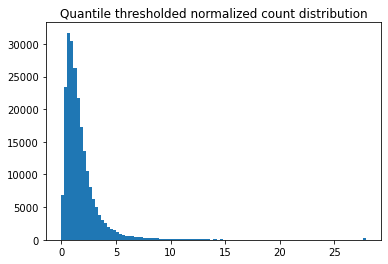

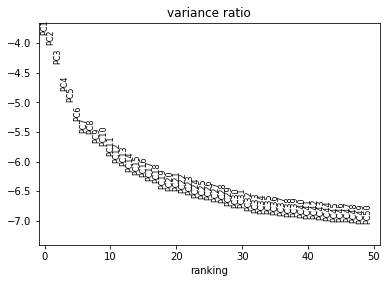

2024-01-01 21:10:54,432 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-01-01 21:12:10,530 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-01-01 21:12:13,284 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2024-01-01 21:16:28,941 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2024-01-01 21:20:39,891 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2024-01-01 21:24:19,924 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [90]:
(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [91]:
adata_tp10k.X = sp.csr_matrix(adata_tp10k.X)

In [92]:
adata_tp10k.var.iloc[:, :7] = adata_tp10k.var.iloc[:, :7].astype(str)

In [93]:
adata_tp10k.var['highly_variable'] = adata_tp10k.var['highly_variable'].astype(str)

In [94]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [51]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [52]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [53]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [54]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((44256, 20807), (44031, 2000), (44031, 20807))

In [55]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.FiltForcNMF.h5ad'

In [56]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


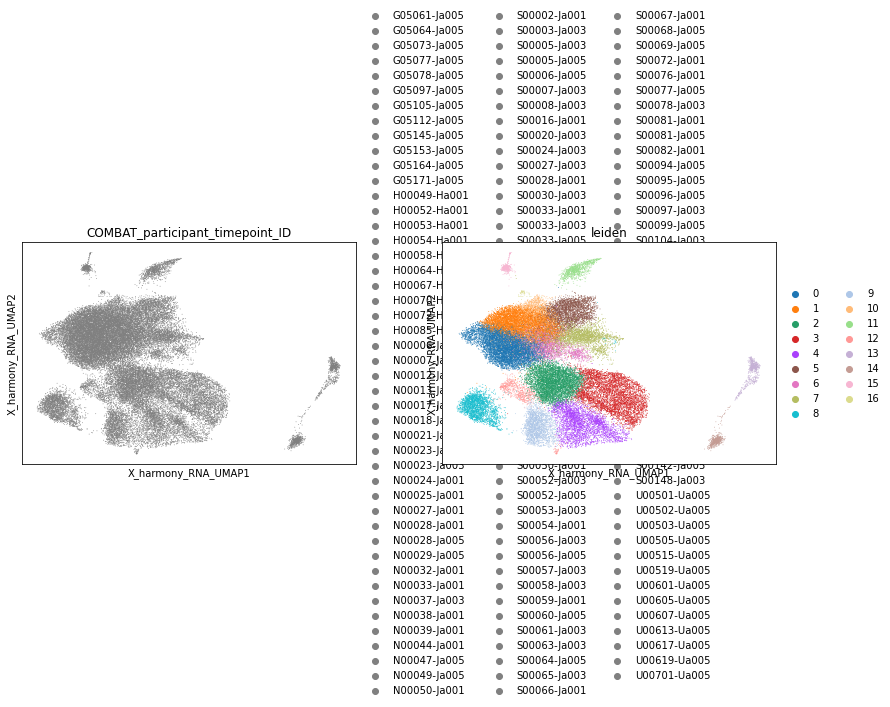

In [57]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

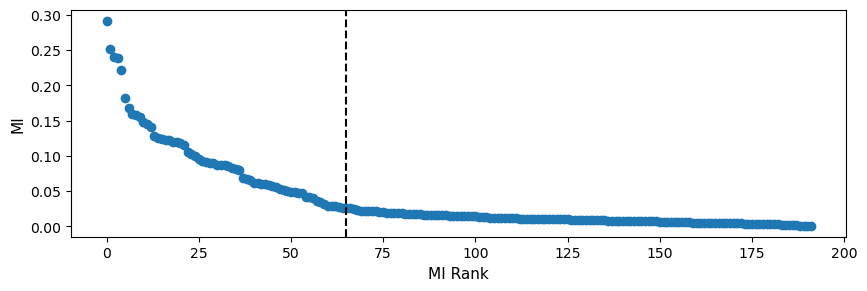

In [60]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [61]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


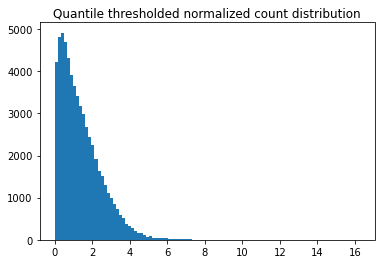

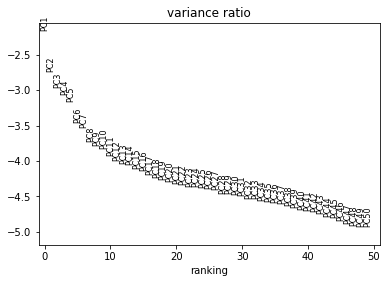

2023-12-31 03:35:29,364 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-31 03:35:51,062 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-31 03:35:51,536 - harmonypy - INFO - Iteration 1 of 20
2023-12-31 03:36:21,197 - harmonypy - INFO - Iteration 2 of 20
2023-12-31 03:36:49,550 - harmonypy - INFO - Iteration 3 of 20
2023-12-31 03:37:19,811 - harmonypy - INFO - Iteration 4 of 20
2023-12-31 03:37:37,833 - harmonypy - INFO - Iteration 5 of 20
2023-12-31 03:37:53,635 - harmonypy - INFO - Iteration 6 of 20
2023-12-31 03:38:08,683 - harmonypy - INFO - Iteration 7 of 20
2023-12-31 03:38:22,922 - harmonypy - INFO - Iteration 8 of 20
2023-12-31 03:38:37,856 - harmonypy - INFO - Iteration 9 of 20
2023-12-31 03:38:52,715 - harmonypy - INFO - Iteration 10 of 20
2023-12-31 03:39:08,095 - harmonypy - INFO - Iteration 11 of 20
2023-12-31 03:39:31,693 - harmonypy - INFO - Iteration 12 of 20
2023-12-31 03:39:55,436 - harmonypy - INFO - Iteration 13 of

In [63]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [64]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [65]:
adata_ADT_c

AnnData object with n_obs × n_vars = 44031 × 65
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 

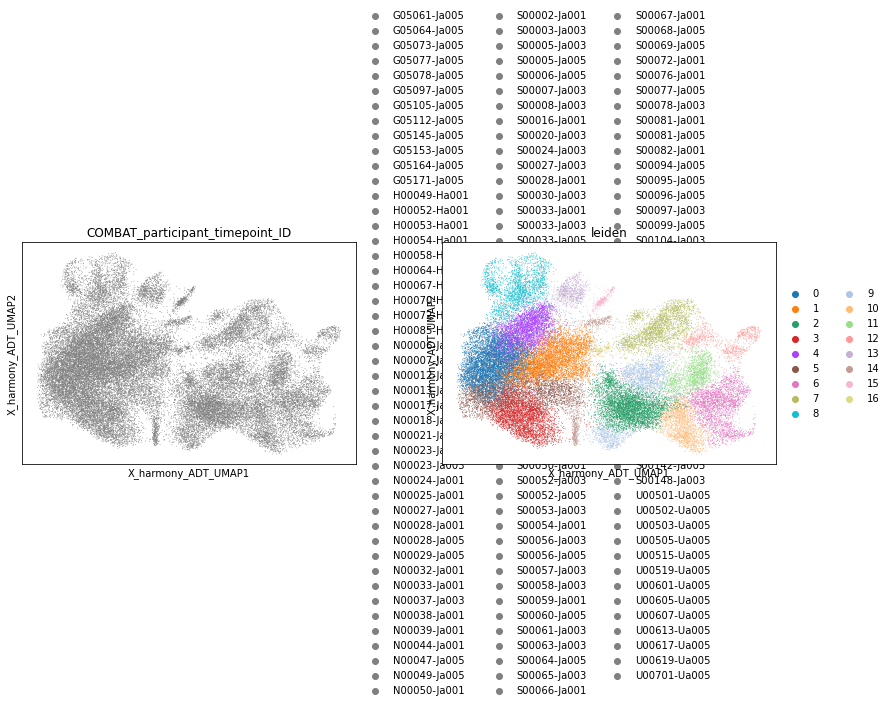

In [66]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [67]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.

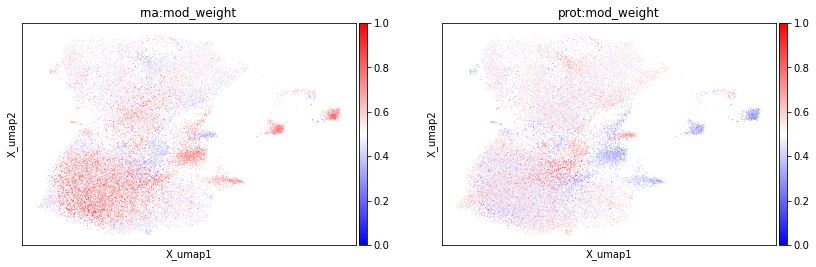

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/tools/_leiden.py:160: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  categories=natsorted(map(str, np.unique(groups))),


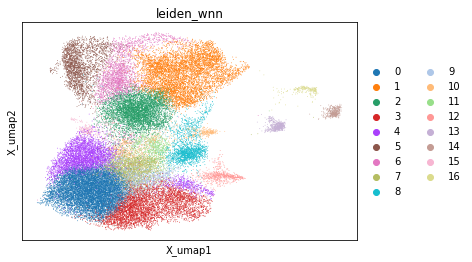

In [68]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [69]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [70]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [71]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [72]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,STAG3,SESN1,ZBTB16,CNTNAP2,RASL11A,UACA,SLC38A11,FAM177B,DSP,SPINK2,MMRN1,CEMIP2,KRT18,ZDHHC19,YBX3,SCN3A,IGKV1-8,GNG8,MLLT3,GAB1
1,EEF1A1,B2M,RPLP1,HSPA8,AIM2,RPL41,RPS12,COCH,SCIMP,SSPN,CPNE5,S100A10,RPS8,RPL10,TEX9,CD74,VIM,ZBTB38,LYPLAL1,PDE4D
2,EEF1A1,GPR183,AIM2,RPL10,RPS8,TNFRSF13B,RPS12,CLECL1,RPL41,GNG11,FCRL2,CD27,IGHG2,B2M,GPM6A,GALNTL6,PMAIP1,CTSH,MYC,KLK1
3,CD9,JUP,IGLL5,PLD4,NEIL1,SOX4,PCDH9,MYO7B,LIMS2,IGHV5-78,TCL1B,MACROD2,CCDC191,BMP3,CCL4,IL7R,YBX3,PPP1R14A,H2AC6,AEBP1
4,IGLC3,IGLV2-14,IGLC2,CD9,IGLC7,IGLC6,NEIL1,IGLV2-5,MYO7B,CCL4,IGLV2-23,IGLV4-69,IGLV9-49,BMP3,DSP,MACROD2,IGLV1-40,TCL1B,IGLVI-70,IGLV3-16
5,CD74,FGR,B2M,FCRL5,CIB1,HCK,FCRL3,PLEK,S100A11,SCIMP,ADGRE5,TMSB4X,GRN,TUBB6,THEMIS2,LRMP,FCRL2,TNFRSF1B,MS4A7,SLC11A1
6,B2M,RPL41,RPS8,CD74,RPLP1,RPL28,RPL10,EEF1A1,RPS12,TNFRSF13B,ACP5,MT-CO1,MT-CO2,PPIA,CIB1,TMSB4X,RPS26,PFN1,VIM,CD1C
7,STAG3,SESN1,ZBTB16,SPINK2,RASL11A,FAM177B,GAB1,CD9,PCDH9,FCER1G,TCL1B,IGKV1-8,DUSP6,CNTNAP2,CEMIP2,IL7R,CCL4,ANXA1,TYROBP,CD2
8,PCDH9,CEMIP2,POU3F3,CR2,SPTBN1,TTN,MUC12,GRIP1,B4GALT1,COL4A4,MYO1E,SEL1L,SYNE2,DOP1B,GAB1,ZBTB16,KLHL14,GOLGB1,DSP,SCN3A
9,IFITM1,IFI44L,XAF1,PLSCR1,MX2,EPSTI1,IFIT3,IRF7,MX1,IFIT1,ISG15,SAMD9L,IFI6,STAT1,OAS3,USP18,IFI44,OAS1,HERC5,PARP9


In [73]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD305,AB_CD73,AB_CD272,AB_CD40,AB_CD47,AB_CD185,AB_CD23,AB_CD124,AB_HLA-DR,AB_CD21
1,AB_HLA_A_B_C,AB_CD58,AB_CD49d,AB_CD82,AB_CD99,AB_CD27-1,AB_CD35,AB_CD224,AB_CD95,AB_CD267
2,AB_CD45RA,AB_CD24,AB_CD32,AB_CD267,AB_CD70,AB_CD44-1,AB_CD82,AB_CD25,AB_CD27-1,AB_CD52
3,AB_Iglightchaink,AB_IgD,AB_CD38-1,AB_CD305,AB_IgM,AB_CD81,AB_CD10,AB_CD79b,AB_CD5,AB_Integrin-7
4,AB_Iglightchainl,AB_IgD,AB_CD305,AB_CD21,AB_IgM,AB_CD81,AB_Integrin-7,AB_CD185,AB_CD272,AB_CD31
5,AB_CD19,AB_CD20,AB_CD32,AB_HLA_A_B_C,AB_CD11c,AB_CD307e,AB_CD52,AB_CD85j,AB_CD107a,AB_CD82
6,AB_CD1c,AB_CD82,AB_IgM,AB_CD58,AB_HLA_A_B_C,AB_CD1d,AB_CD49d,AB_CD27-1,AB_CD45RA,AB_CD54
7,AB_CD11b-1,AB_CD57,AB_abTCR,AB_gdTCR,AB_CCR7,AB_CD124,AB_CD5,AB_CD23,AB_CD73,AB_CD305
8,AB_CD57,AB_CD11b-1,AB_CD47,AB_abTCR,AB_IgD,AB_CD31,AB_CD21,AB_CCR7,AB_gdTCR,AB_CD184
9,AB_CD305,AB_IgD,AB_CD272,AB_CD47,AB_CD21,AB_CD31,AB_CD185,AB_CD57,AB_CD23,AB_CD40


In [74]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [75]:
paths['WNN_UMAP']

'../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [76]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [77]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [78]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [79]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [80]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
